In [83]:
from dotenv import load_dotenv
load_dotenv()

True

In [84]:
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model='text-embedding-3-large')

### 처음 데이터 생성 시에만 확인하기 //// 데이터 로딩

In [85]:
from langchain_chroma import Chroma

# 처음 데이터 생성 시에만
# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding,
#     collection_name='chroma-tax',
#     persist_directory='./chroma-tax'
# )

## 데이터 로딩 
vector_store = Chroma(
    collection_name='chroma-tax',
    embedding_function=embedding,
    persist_directory='./chroma-tax'
)

retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [86]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [87]:
def retrieve(state: AgentState) -> AgentState:
    """ 
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state
    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.        
    """

    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [88]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

### 내가 해본 방법

In [68]:
# 검색
def retrieve(state: AgentState) -> AgentState:
    query = state["query"]
    docs = retriever.get_relevant_documents(query)
    return {**state, "context": docs}

# 답변 생성
def generate(state: AgentState) -> AgentState:
    context_texts = "\n".join([d.page_content for d in state["context"]])
    answer = llm.invoke(f"질문: {state['query']}\n\n참고 문맥:\n{context_texts}")
    return {**state, "answer": answer.content}

# 질문 리라이트
def rewrite(state: AgentState) -> AgentState:
    new_query = llm.invoke(f"다음 질문을 더 검색 친화적으로 다시 써줘: {state['query']}")
    return {**state, "query": new_query.content}

In [49]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(AgentState)

# 노드 등록
builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)
builder.add_node("rewrite", rewrite)

# 분기 연결
builder.add_edge(START, "retrieve")

# retrieve → generate or rewrite (조건 분기)
def branch_after_retrieve(state: AgentState):
    if len(state["context"]) > 0:   
        return "generate"
    else:                           
        return "rewrite"

builder.add_conditional_edges("retrieve", branch_after_retrieve,
                              {"generate": "generate", "rewrite": "rewrite"})

# generate → END
builder.add_edge("generate", END)

# rewrite → retrieve (루프)
builder.add_edge("rewrite", "retrieve")

graph = builder.compile()


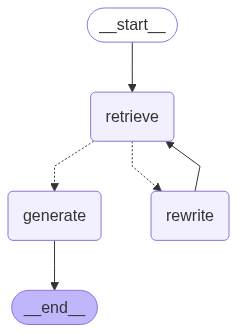

In [50]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
inputs = {"query": "연봉 5천만원 직장인의 소득세는? ", "context": [], "answer": ""}
result = graph.invoke(inputs)
print(result["answer"])

연봉 5천만원인 직장인의 소득세를 계산하기 위해서는 기본적으로 근로소득세의 계산 과정을 이해해야 합니다. 한국의 근로소득세는 총급여에서 일정 금액을 공제한 후, 남은 과세표준에 대해 세율을 적용하여 계산됩니다. 다음은 일반적인 계산 과정입니다:

1. **총급여**: 연봉 5천만원

2. **근로소득공제**: 총급여에서 차감할 금액으로, 급여에 따라 공제액이 다릅니다. 2023년 기준으로, 연봉 5천만원의 경우 근로소득공제는 약 1100만원 정도가 됩니다.

3. **과세표준**: 총급여에서 근로소득공제를 차감한 금액입니다.
   \[
   \text{과세표준} = 50,000,000 - 11,000,000 = 39,000,000 \text{원}
   \]

4. **세율 적용**: 소득세율은 과세표준 구간에 따라 다르게 적용됩니다. 2023년 기준으로 과세표준 12,000,000원 초과 46,000,000원 이하 구간에 해당하는 세율은 15%입니다.
   \[
   \text{소득세} = 39,000,000 \times 0.15 - \text{누진공제액}
   \]
   여기서, 누진공제액은 해당 구간에 대해 약 1,080,000원입니다.

5. **계산 결과**:
   \[
   \text{소득세} = (39,000,000 \times 0.15) - 1,080,000 = 4,770,000 \text{원}
   \]

6. **세액공제**: 근로소득세액공제 등을 통해 최종적으로 납부할 세액이 줄어들 수 있습니다. 이 공제는 공제대상에 따라 다르므로 정확한 계산을 위해서는 개인별 공제 항목을 확인해야 합니다. 예를 들어, 일반적인 근로소득세액공제는 55만원입니다.

따라서, 최종적으로 납부할 소득세는 약 4,220,000원이 됩니다. 그러나 이는 개인별 상황에 따라 다를 수 있으므로, 정확한 계산을 위해서는 국세청의 소득세 계산기를 활용하거나 세무 전문가와 상담하는 것이 좋습니다.


### 강사님 버전

In [103]:
from langchain import hub

generate_prompt = hub.pull('rlm/rag-prompt')

def generate(state: AgentState) -> AgentState:
    """ 
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state
    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.        
    """
    context = state['context']
    query = state['query']

    rag_chain = generate_prompt | llm

    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response}

c:\workspace\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [104]:
from langchain import hub
from typing import Literal

doc_releveance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevence(state: AgentState) -> Literal['relevant', 'irrelevant']:
    """ 
    주어진 state를 기반으로 문서의 관련성을 판단합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state
    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇치 않으면 'irrelevant' 를 반환합니다.       
    """

    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_releveance_prompt | llm

    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'
    
    return 'irrelevant'

c:\workspace\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [105]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사랑과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리 사전을 참고해서 사용자의 질문을 변경해 주세요.
사전: {dictionary}
질문: {{query}}
""")

def rewrite(state=AgentState) -> AgentState:
    """
    사용자의 질문을 사전에 고려하여 변경합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state
    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.   
    """
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})

    return {'query': response}

In [111]:
from langchain_core.output_parsers import StrOutputParser

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}
student_answer: {student_answer}
""")

hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})

    print('거짓말: ', response)

    return response

### 초기값 넣어서 테스트

In [112]:
# query = '연봉 5천만원 거주자의 소득세는 얼마인가요?'
query = '연봉 5천 세금 얼마?'

context = retriever.invoke(query)
generate_state = {'query': query, 'context': context}
answer = generate(generate_state)
print(f'answer: {answer}')

hallucination_state = {'answer': answer, 'context': context}
check_hallucination(hallucination_state)

answer: {'answer': AIMessage(content='연봉 5천만 원의 세금을 계산하기 위해서는 소득세율과 여러 공제 항목을 고려해야 합니다. 일반적으로 연봉 5천만 원에 대한 소득세는 약 5%에서 15% 범위 내에서 결정될 수 있으며, 개인의 공제 조건에 따라 달라집니다. 정확한 금액은 세무 전문가나 소득세 계산기를 통해 확인하는 것이 좋습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 3015, 'total_tokens': 3109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2944}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run--c39e4699-463a-46f5-8be6-fb7d6702a73c-0', usage_metadata={'input_tokens': 3015, 'output_tokens': 94, 'total_tokens': 3109, 'input_token_details': {'audio': 0, 'cache_read': 2944}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}
거짓말:  hallucinated


'hallucinated'

In [116]:
from langchain import hub

helpfulness_prompt = hub.pull('langchain-ai/rag-answer-helpfulness')

def check_helpfulness_grader(state: AgentState) -> Literal['helpful', 'unhelpful']:
    """
    사용자의 질문에 기반하여 생성된 답변의 유용성을 평가합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state
    Returns:
        Literal['helpful', 'unhelpful']: 답변이 유용하다고 판단되면 'helpful', 그렇지 않다면 'unhelpful'을 반환합니다.
    """
    query = state['query']
    answer = state['answer']

    helpfulness_chain = helpfulness_prompt | llm
    response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})

    if response['Score'] == 1:
        print('유용성: helpful')
        return 'helpful'
    
    print('유용성: unhelpful')
    return 'unhelpful'

c:\workspace\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [117]:
def check_helpfulness(state: AgentState) -> AgentState:
    """
    유용성을 확인하는 자리 표시자 함수입니다.
    """
    return state

In [118]:
query = '연봉 5천만원 거주자의 소득세는 얼마인가요?'
# query = '연봉 5천 세금 얼마?'

context = retriever.invoke(query)
generate_state = {'query': query, 'context': context}
answer = generate(generate_state)
print(f'answer: {answer}')

helpfulness_state = {'answer': answer, 'query': query}
check_helpfulness_grader(helpfulness_state)

answer: {'answer': AIMessage(content='연봉 5천만 원인 거주자의 소득세는 624만 원입니다. 이는 5천만 원 초과 8,800만 원 이하 구간에 해당하며, 5천만 원을 초과하는 금액에 대해 24%의 세율이 적용됩니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 3061, 'total_tokens': 3126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2944}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'finish_reason': 'stop', 'logprobs': None}, id='run--7a629173-df0d-4e46-961d-4994bc55793e-0', usage_metadata={'input_tokens': 3061, 'output_tokens': 65, 'total_tokens': 3126, 'input_token_details': {'audio': 0, 'cache_read': 2944}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}
유용성: helpful


'helpful'

### 혼자 해보기 그래프

In [127]:
builder = StateGraph(AgentState)

builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)
builder.add_node('rewrite', rewrite)
builder.add_node('check_helpfulness',check_helpfulness)

In [128]:
from langgraph.graph import START, END

builder.add_edge(START, "retrieve")   
builder.add_conditional_edges(
    "retrieve",
    check_doc_relevence,
    {
        "relevant": "generate",     # 문서 관련 있으면 → generate
        "irrelevant": END     # 문서 관련 없으면 → rewrite → END
    }
)
builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)
builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
builder.add_edge("rewrite", "retrieve")   # rewrite 후 다시 검색

In [129]:
graph = builder.compile()

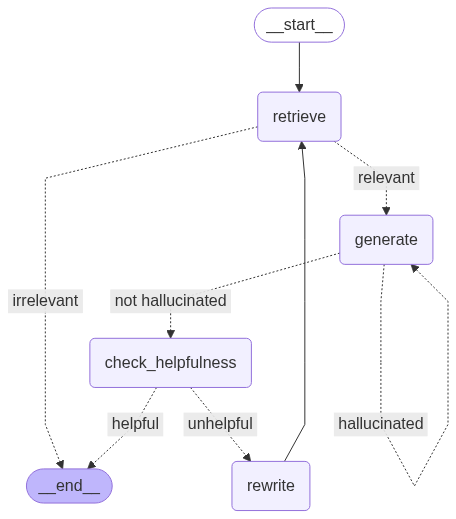

In [130]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [134]:
# test
initial_state = {"query": "연봉 5천만원 거주자의 소득세는 얼마인가요?"}
response = graph.invoke(initial_state)

거짓말:  not hallucinated
유용성: helpful


In [136]:
response

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='제55조(세율) ①거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n\n| 종합소득 과세표준          | 세율                                         |\n\n|-------------------|--------------------------------------------|\n\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n\n| 8,800만원 초과 1억5천만원 이하    | 3,706만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|\n\n\n\n\n\n② 거주자의 퇴직소득에 대한 소득세는 다음 

In [137]:
print(response['answer'].content)

연봉 5천만원인 거주자의 소득세는 624만원입니다. 이는 과세표준 5천만원 이하 구간에 해당하며, 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)로 계산됩니다. 5천만원 - 1,400만원 = 3,600만원에 15%를 적용한 540만원을 더하면 총 624만원입니다.
